## Initial configuration

In [130]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
import gc
from tqdm import tqdm,trange

import torch
from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

import urllib.request
import zipfile
import json

In [131]:
#Usefull for better outputs visualization
PURPLE = "\033[95m"
CYAN = "\033[96m"
DARKCYAN = "\033[36m"
BLUE = "\033[94m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"
END = "\033[0m"

### Project settings

In [142]:
data_dir_unsplitted = "dataset/unsplitted"
save_dir_splitted = "dataset/splitted"
data_dir = "dataset/splitted"
models_dir ="models/" #the resuls will be saved here

os.makedirs(models_dir,exist_ok=True)

np.random.seed(42) 

patch_size = 64
n_samples_train = 40
n_samples_valtest = 40
batch_size = 75


grayscale= False
resize_to= None
fft = False


learning_rate= 0.001
num_epochs = 70


#@DEPRECATED VARIABLE
#ALREADY_SPLITTED = True #-> we will use only "LOAD_DATASET"


LOAD_DATASET = True

#to be implemented:

DATASET_ALREADY_DOWNLOADED = True 
DATASET_ALREADY_UNZIPPED = True

LOAD_MODEL = False 
MODEL_ALREADY_DOWNLOADED = True 

## Dataset preparation

### Dataset splitting and data augmentation

In [79]:
classes = ["CLL", "FL", "MCL"]
id_to_name = {0:"CLL",1:"FL",2:"MCL"}

if(not LOAD_DATASET):
    data = []
    labels = []
    for i, cl in enumerate(classes):
        path = os.path.join(data_dir_unsplitted, cl)
        images = os.listdir(path)
        for img in tqdm(images,desc=cl):
            img_path = os.path.join(path, img)
            img = cv2.imread(img_path).astype(np.uint8)
            
            data.append(img)
            labels.append(i) 


    data = np.array(data)
    labels = np.array(labels)


    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.125, random_state=42)

    print("Train samples:", len(train_data))
    print("Test samples:", len(test_data))
    print("Validation samples:", len(val_data))

MCL: 100%|██████████████████████████████████████████████████████████████████████████| 122/122 [00:01<00:00, 113.94it/s]


Train samples: 261
Test samples: 75
Validation samples: 38


### Saving the splitted dataset

In [80]:
def crop_image(image, patch_size, n_samples = 40):
    h, w, _ = image.shape
    h_eff = h - patch_size
    w_eff = w - patch_size
    samples = []
    
    for i in range(n_samples):
        h_vertex = np.random.randint(h_eff)
        w_vertex = np.random.randint(w_eff)
        samples.append(image[h_vertex:h_vertex+patch_size, w_vertex:w_vertex+patch_size, :])
    
    samples = np.stack(samples)
    return samples   

In [81]:
#SAVING THE DATASET
if(not LOAD_DATASET):
    #TRAIN
    os.makedirs(os.path.join(save_dir_splitted,"train","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"train","labels_patch"),exist_ok=True)
     
    train_labels_dict={}
    train_labels_patch_dict={}
    
    for i, image in enumerate(tqdm(train_data,desc = "Train")):                       #images
        file_name = str(i)+"_train"+".png"
        
        path = os.path.join(save_dir_splitted,"train","images",file_name)
        train_labels_dict[file_name] = int(train_labels[i])
        cv2.imwrite(path,image.astype(np.float64))
        
        image_patch = crop_image(image, patch_size, n_samples_train)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_train"+".png"
            path = os.path.join(save_dir_splitted,"train","images_patch",file_name)
            train_labels_patch_dict[file_name] = int(train_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))
       
    
    
    with open(os.path.join(save_dir_splitted,"train","labels","train.json"), 'w') as f:
        json.dump(train_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"train","labels_patch","train_patch.json"), 'w') as f:
        json.dump(train_labels_patch_dict, f)#labels

    #TEST
    os.makedirs(os.path.join(save_dir_splitted,"test","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"test","labels_patch"),exist_ok=True)

    test_labels_dict={}
    test_labels_patch_dict={}
    
    for i, image in enumerate(tqdm(test_data,desc = "Test")):                      #images
        file_name = str(i)+"_test"+".png"
        path = os.path.join(save_dir_splitted,"test","images",file_name)
        
        cv2.imwrite(path,image.astype(np.float64))
        test_labels_dict[file_name] = int(test_labels[i]) 
        
        image_patch = crop_image(image, patch_size, n_samples_valtest)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_test"+".png"
            path = os.path.join(save_dir_splitted,"test","images_patch",file_name)
            test_labels_patch_dict[file_name] = int(test_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))

    with open(os.path.join(save_dir_splitted,"test","labels","test.json"), 'w') as f:
        json.dump(test_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"test","labels_patch","test_patch.json"), 'w') as f:
        json.dump(test_labels_patch_dict, f)#labels
        
    #VALIDATION
    os.makedirs(os.path.join(save_dir_splitted,"val","images"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","images_patch"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","labels"),exist_ok=True)
    os.makedirs(os.path.join(save_dir_splitted,"val","labels_patch"),exist_ok=True)
    
    val_labels_dict = {}
    val_labels_patch_dict = {}
    
    for i, image in enumerate(tqdm(val_data,desc = "Validation")):               #images
        file_name = str(i)+"_val"+".png"
        path = os.path.join(save_dir_splitted,"val","images",file_name)
        
        cv2.imwrite(path,image.astype(np.float64))
        val_labels_dict[file_name] = int(val_labels[i])
        
        image_patch = crop_image(image, patch_size, n_samples_valtest)
        for j in range(len(image_patch)):
            file_name = str(i)+"-"+str(j)+"_val"+".png"
            path = os.path.join(save_dir_splitted,"val","images_patch",file_name)
            val_labels_patch_dict[file_name] = int(val_labels[i])
            cv2.imwrite(path,image_patch[j].astype(np.float64))
        
    with open(os.path.join(save_dir_splitted,"val","labels","val.json"), 'w') as f:
        json.dump(val_labels_dict, f)#labels
    with open(os.path.join(save_dir_splitted,"val","labels_patch","val_patch.json"), 'w') as f:
        json.dump(val_labels_patch_dict, f)#labels

Validation: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.84it/s]


### Dataloaders definition

Notice that the labels are saved into a numpy array, while the images are read directly from the folder

In [98]:
class HDAdataset(Dataset):
    def __init__(self, root_dir, labels, train = False, transform=None, grayscale= False, resize_to= None, fft = False):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        self.train = train
        self.grayscale=grayscale
        self.fft = fft
        self.resize_to = resize_to

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        if self.grayscale or self.fft:
            image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            
        else:
            image = cv2.imread(img_path)

        
        if self.train:
            image = image.astype(np.uint8) + np.random.normal(0, 2, image.shape).astype(np.uint8)
        
        if self.resize_to is not None:
            image = cv2.resize(image, resize_to, interpolation= cv2.INTER_LINEAR)
            
        if self.fft:
            image = np.fft.fft2(image)
            fshift = np.fft.fftshift(image)
            magnitude_spectrum = 20*np.log(np.abs(fshift))
            image = magnitude_spectrum
        

    
        #labels smoothing
        label = 0.1*np.ones(3)
        label[self.labels[img_name]] = 0.8
        
        if self.transform:
            image = self.transform((image/255.).astype(np.float32))

        return image, label

In [99]:
class HDAdatasetPatches(Dataset):
    def __init__(self, root_dir,patch_dir, labels, train = False, grayscale= False, fft = False):
        self.root_dir = root_dir
        self.patch_dir = patch_dir
        self.labels = labels
        self.train = train
        self.grayscale=grayscale
        self.fft = fft

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img_id = int(img_name.split("_")[0])
        
        patches_list = os.listdir(self.patch_dir)
        patches_image_list = list(filter(lambda name: int(name.split("-")[0]) == img_id, patches_list))
        
        all_patches = []
        for patch in patches_image_list:
            patch_path = os.path.join(self.patch_dir, patch)
            

            if self.grayscale or self.fft:
                image = cv2.imread(patch_path,cv2.IMREAD_GRAYSCALE)
                channels = 1
            
            else:
                image = cv2.imread(patch_path)
                channels = 3

            if self.train:
                image = image.astype(np.uint8) + np.random.normal(0, 2, image.shape).astype(np.uint8)

            if self.fft:
                image = np.fft.fft2(image)
                fshift = np.fft.fftshift(image)
                magnitude_spectrum = 20*np.log(np.abs(fshift))
                image = magnitude_spectrum
            
            image = (image/255.).astype(np.float32)
            image = image.reshape(image.shape[0],image.shape[1],channels)
            image = np.transpose(image, (2, 0, 1))
            all_patches.append(image.reshape(1,image.shape[0],image.shape[1],image.shape[2]))

        all_patches=np.stack(all_patches)
        
        #labels smoothing
        label = 0.1*np.ones(3)
        label[self.labels[img_name]] = 0.8

        return all_patches, label.reshape(1,label.shape[0])

In [100]:
if(LOAD_DATASET and not DATASET_ALREADY_DOWNLOADED):
    
    print("download and extract the datasets")
    urllib.request.urlretrieve("", "dataset.zip")
    
    with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("./dataset/")

        
#convert to tensor each image
transform = transforms.Compose([transforms.ToTensor()])    


#TRAIN DATASET AND DATALOADER
train_dir = os.path.join(data_dir,"train","images_patch")#images
train_labels_dir = os.path.join(data_dir,"train","labels_patch","train_patch.json")
with open(train_labels_dir) as f:
    train_labels = json.load(f)#labels

train_dataset = HDAdataset(train_dir,train_labels,train = True, transform=transform
                           ,grayscale=grayscale,fft=fft)

#using a list to increase the training speed since the data fit in the ram
train_data = [data for data in tqdm(train_dataset,desc="Generating the train set list")] 

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)


#TEST DATASET
test_dir = os.path.join(data_dir,"test","images")#images
test_dir_patches = os.path.join(data_dir,"test","images_patch")#patches
test_labels_dir = os.path.join(data_dir,"test","labels","test.json")
with open(test_labels_dir) as f:
    test_labels = json.load(f)#labels

test_dataset = HDAdatasetPatches(test_dir,test_dir_patches,test_labels,train = False,
                          grayscale=grayscale,fft=fft)


#VALIDATION DATASET
val_dir = os.path.join(data_dir,"val","images")#images
val_dir_patches = os.path.join(data_dir,"val","images_patch")#patches
val_labels_dir = os.path.join(data_dir,"val","labels","val.json")
with open(val_labels_dir) as f:
    val_labels = json.load(f)#labels

val_dataset = HDAdatasetPatches(val_dir,val_dir_patches,val_labels,train = False,
                          grayscale=grayscale,fft=fft)

Generating the train set list: 100%|████████████████████████████████████████████| 10440/10440 [01:15<00:00, 137.94it/s]


In [101]:
def compute_weight(dataset):
    count = {0:0,1:0,2:0}
    for data in tqdm(dataset,desc = "Computing class weight"):
        label = data[1]
        count[label.argmax()]= count[label.argmax()]+1
    
    count = np.array([count[0],count[1],count[2]])
    total = count.sum()
    return count/total

In [102]:
weights = compute_weight(train_data)

Computing class weight: 100%|████████████████████████████████████████████████| 10440/10440 [00:00<00:00, 392015.59it/s]


In [103]:
weights.sum()

1.0

## Neural network

In [143]:
torch.cuda.empty_cache()
gc.collect()

8

### Models definition

In [144]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #encoder
        self.convE1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convE2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convE3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.flatten = nn.Flatten()
        self.BNE16 = nn.BatchNorm2d(16)
        self.BNE32 = nn.BatchNorm2d(32)
        self.BNE64 = nn.BatchNorm2d(64)
        self.linearE1 = nn.Linear(3136,50)
        self.linearE2 = nn.Linear(50,3)
        self.BNE150linear = nn.BatchNorm1d(50)
        
        self.act = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.1)
        
        #decoder
        
        self.convD1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convD2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(0,0))
        self.convD3 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=(3,3), 
                                         stride=(2,2), padding=(0,0), dilation=1,output_padding=(1,1))
        self.reshape = nn.Unflatten(-1, (64,7,7))
        self.BND16 = nn.BatchNorm2d(16)
        self.BND32 = nn.BatchNorm2d(32)
        self.linearD1 = nn.Linear(3,50)
        self.linearD2 = nn.Linear(50,3136)
        self.BND150linear = nn.BatchNorm1d(50)
        self.BND16klinear = nn.BatchNorm1d(3136)
        
        self.out = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):

        x1 = self.act(self.BNE16(self.convE1(x)))
        x2 = self.act(self.BNE32(self.convE2(x1)))
        x3 = self.act(self.BNE64(self.convE3(x2)))
        x3linear = self.flatten(x3)
        x4 = self.drop(self.act(self.BNE150linear(self.linearE1(x3linear))))
        x5 = self.linearE2(x4)

        x = self.act(self.BND150linear(self.linearD1(x5)))
        x = self.act(self.BND16klinear(self.linearD2(x+x4)))
        x = self.reshape(x)
        x = self.act(self.BND32(self.convD1(x+x3)))
        x = self.act(self.BND16(self.convD2(x+x2)))
        x = self.out(self.convD3(x+x1))

        return x,self.softmax(x5)


In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(BOLD+"You are working on: "+END+str(device))

You are working on: cuda


### Loading of the models

In [146]:
if(LOAD_MODEL and not MODEL_ALREADY_DOWNLOADED):
    print("download the model")

In [147]:
if(not LOAD_MODEL):
    autoencoder = Autoencoder().to(device)
    

In [148]:
summary(autoencoder, (3, 64, 64), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [75, 16, 31, 31]             448
       BatchNorm2d-2           [75, 16, 31, 31]              32
         LeakyReLU-3           [75, 16, 31, 31]               0
            Conv2d-4           [75, 32, 15, 15]           4,640
       BatchNorm2d-5           [75, 32, 15, 15]              64
         LeakyReLU-6           [75, 32, 15, 15]               0
            Conv2d-7             [75, 64, 7, 7]          18,496
       BatchNorm2d-8             [75, 64, 7, 7]             128
         LeakyReLU-9             [75, 64, 7, 7]               0
          Flatten-10                 [75, 3136]               0
           Linear-11                   [75, 50]         156,850
      BatchNorm1d-12                   [75, 50]             100
        LeakyReLU-13                   [75, 50]               0
          Dropout-14                   

### Training 

The accuracy in the training is patch wise while the accuracy in validation and test is image wise(i.e. the most common class for the patches of the same image)

In [149]:
def test(dataset,name):
    
    losses_ae = []
    losses_c = []
    count_correct = 0
    count_input = 0

    autoencoder.eval()
    
    #single image
    for data in tqdm(dataset,desc = name +" set"):
        pred = []
        labels = torch.tensor(data[1]).to(device)
        
        #iterate over all the patches
        for patch in data[0]:
            
            img = torch.tensor(patch).to(device)
            
            rec_img,pred_labels= autoencoder(img)  
            
            classifier_loss = criterion_classifier(pred_labels, labels)
            ae_loss= criterion_ae(img,rec_img)
            

            losses_ae.append(ae_loss.detach().cpu().numpy())
            losses_c.append(classifier_loss.detach().cpu().numpy())
            
            pred.append(pred_labels.to("cpu").detach().numpy().argmax(axis=1)[0])
            
            
        count_input += 1
            
        final_image_label = max(set(pred), key=pred.count) 
        true_image_label = labels.to("cpu").detach().numpy().argmax(axis=1)[0]
        count_correct+= (final_image_label == true_image_label)
        
        del img
        del labels
        torch.cuda.empty_cache()
        gc.collect();

    # Print loss at end of each epoch
    accuracy= (count_correct/count_input)*100.
    print(name+': Autoencoder Loss: %.4f, Classifier Loss: %.4f, Accuracy: %.4f in %d input samples\n'
      % (np.mean(losses_ae), np.mean(losses_c),accuracy,count_input))
    
    return np.mean(losses_ae),np.mean(losses_c),accuracy

In [150]:
criterion_classifier = nn.CrossEntropyLoss(weight = torch.tensor(weights).to(device())
criterion_ae = nn.MSELoss()

def train(train_dataloader,val_dataset):
    optimizer_ae = optim.RMSprop(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-2)

    
    
    best_epoch = 0 #(based on the validation accuracy)
    best_accuracy = -np.inf
    
    #for plotting
    train_loss_ae_trend = []
    train_loss_c_trend = []
    train_accuracy_trend =[]
    val_loss_ae_trend = []
    val_loss_c_trend = []
    val_accuracy_trend = []

    
    for epoch in range(num_epochs):

        ######training#####
        losses_ae = []
        losses_c = []
        count_correct = 0
        count_input = 0

        autoencoder.train()
       
        
        #train classifier for one epoch    
        for data in tqdm(train_dataloader,desc = "TRAIN Epoch [%d/%d]"%(epoch+1,num_epochs)):

            img, labels = data
            img = img.to(device)
            labels = labels.to(device)
        
        
            optimizer_ae.zero_grad()
            
            
            rec_img,pred_labels= autoencoder(img)  
            

            classifier_loss = criterion_classifier(pred_labels, labels)
            ae_loss = criterion_ae(img,rec_img)
            total_loss = classifier_loss+30*ae_loss
            
            total_loss.backward()
            
            optimizer_ae.step()
            
            losses_ae.append(ae_loss.detach().cpu().numpy())
            losses_c.append(classifier_loss.detach().cpu().numpy())

            
            count_input+=pred_labels.detach().cpu().numpy().shape[0]
            count_correct+=np.sum((labels.to("cpu").detach().numpy().argmax(axis=1)==pred_labels.to("cpu").detach().numpy().argmax(axis=1)))
            del img
            del labels
            torch.cuda.empty_cache()
            gc.collect();
            
        accuracy = (count_correct/count_input)*100.
        
        print('TRAIN: Epoch [%d/%d], Autoencoder Loss: %.4f, Classifier Loss: %.4f, Accuracy: %.4f in %d input patches \n'
              % (epoch+1, num_epochs, np.mean(losses_ae), np.mean(losses_c),accuracy,count_input))
        
        train_loss_ae_trend.append(np.mean(losses_ae))
        train_loss_c_trend.append(np.mean(losses_c))
        train_accuracy_trend.append(accuracy)
        
        ######validation######
        ae,c,acc = test(val_dataset,"VALIDATION")
        
        val_loss_ae_trend.append(ae)
        val_loss_c_trend.append(c)
        val_accuracy_trend.append(acc)
        
        if acc > best_accuracy:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best validation accuracy reached\n\n"+END)
            best_epoch = epoch+1
            torch.save(autoencoder.state_dict(), os.path.join(models_dir,"best_ae.pt"))
            
            best_accuracy = acc
        

    return np.array([[train_loss_ae_trend,train_loss_c_trend,train_accuracy_trend],
            [val_loss_ae_trend,val_loss_c_trend,val_accuracy_trend],best_epoch],dtype=np.object_)

SyntaxError: invalid syntax (673963577.py, line 2)

In [ ]:
#training or loading the results of a pre-trained model
if(not LOAD_MODEL):
    
    results = train(train_dataloader,val_dataset) 
    np.save(os.path.join(models_dir,"results.npy"),results)
    
else: 
    results = np.load(os.path.join(models_dir,"results.npy"),allow_pickle=True)

TRAIN Epoch [1/70]:  11%|██████▌                                                      | 15/139 [00:01<00:13,  8.98it/s]

In [ ]:
#always load the best model after the training
autoencoder =  Autoencoder().to(device)
autoencoder.load_state_dict(torch.load(os.path.join(models_dir,"best_ae.pt")))
autoencoder.eval();

### Plot of the losses and accuracy

In [190]:
#train
train_ae = results[0][0] #mse
train_c = results[0][1] #cross entropy
train_acc = results[0][2] #accuracy

#validation
val_ae = results[1][0] #mse
val_c = results[1][1] #cross entropy
val_acc = results[1][2] #accuracy

#best epoch number
best_epoch = results[2]

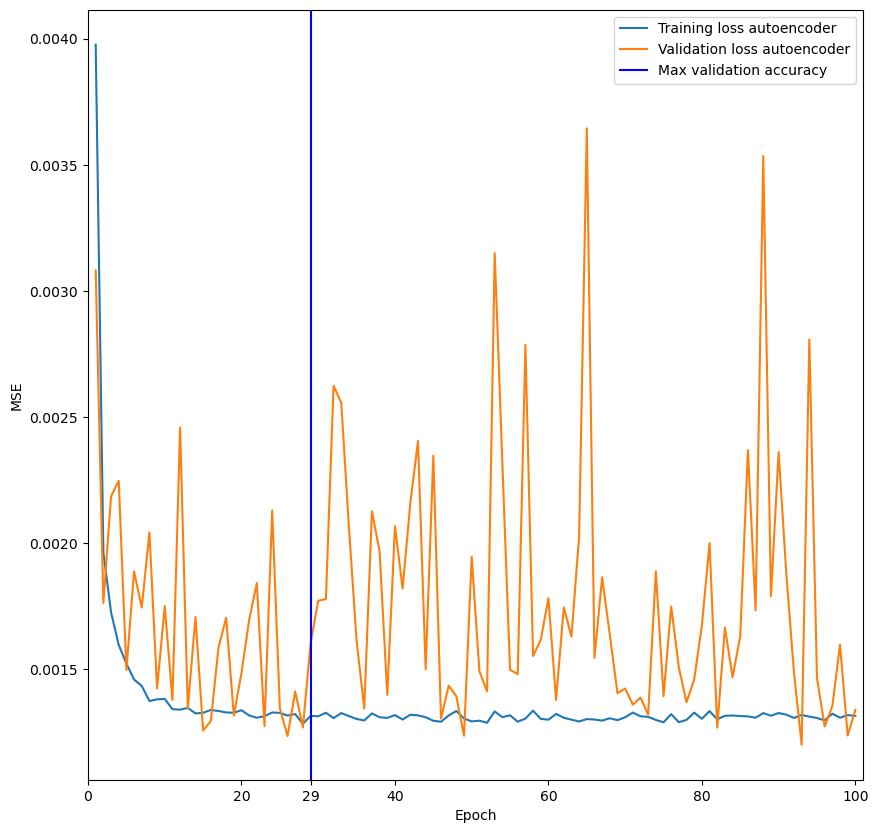

In [191]:
#generating the batch indexes
batchID = np.array([i+1 for i in range(len(train_ae))])

plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_ae,label = "Training loss autoencoder")
plt.plot(batchID,val_ae, label = "Validation loss autoencoder")
plt.xlabel("Epoch")
plt.ylabel("MSE")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])

#limit the plot x-values
plt.xticks(ticks)

plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig("training-val_mse")
plt.show()

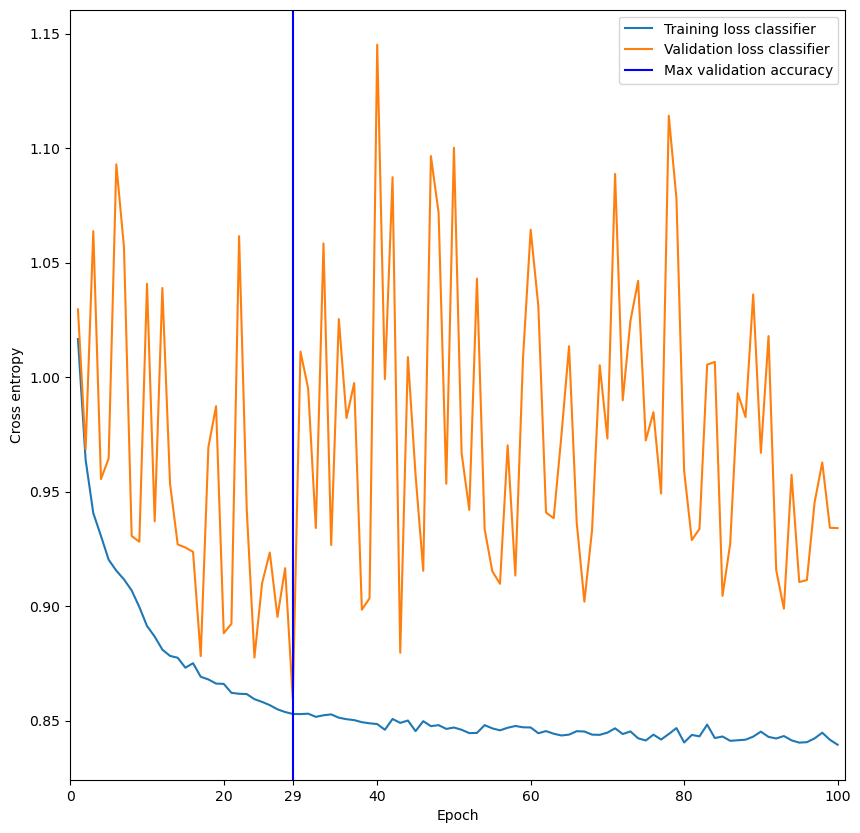

In [192]:
plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,train_c,label = "Training loss classifier")
plt.plot(batchID,val_c, label = "Validation loss classifier")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)

#limit the plot x-values
plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig("train-val_ce")
plt.show()

100 100


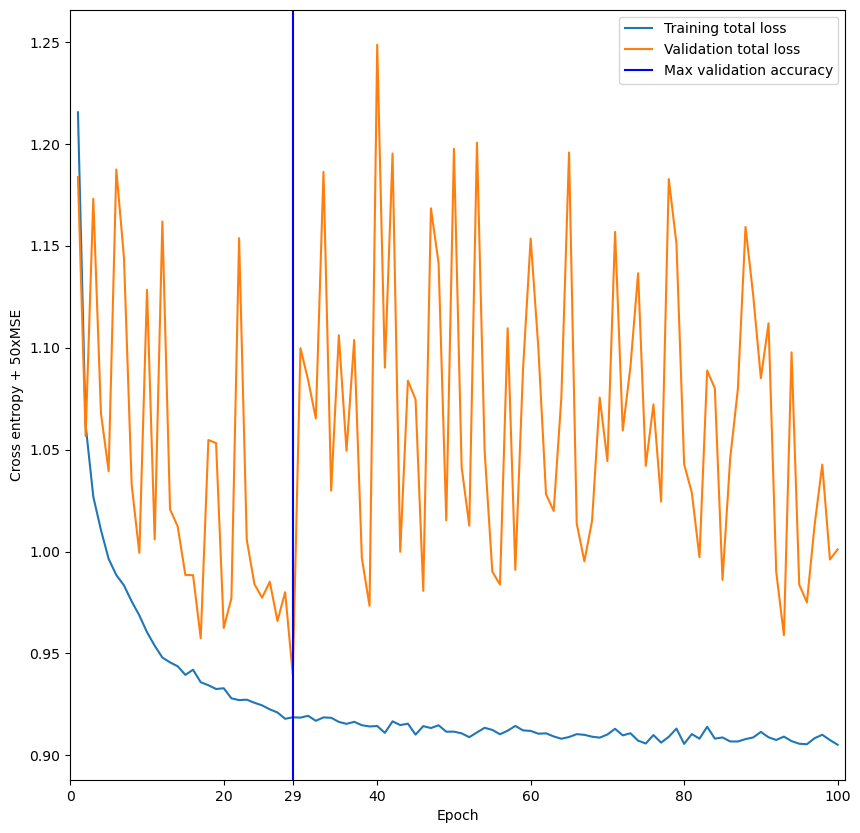

In [200]:
plt.figure(figsize=(10,10))

print(len(batchID),len(train_c+50*np.ones(len(batchID))*train_ae))

#plotting the losses
plt.plot(batchID,train_c+50*np.ones(len(batchID))*train_ae,label = "Training total loss")
plt.plot(batchID,val_c+50*np.ones(len(batchID))*val_ae, label = "Validation total loss")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy + 50xMSE")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)

#limit the plot x-values
plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig("train-val_totalloss")
plt.show()

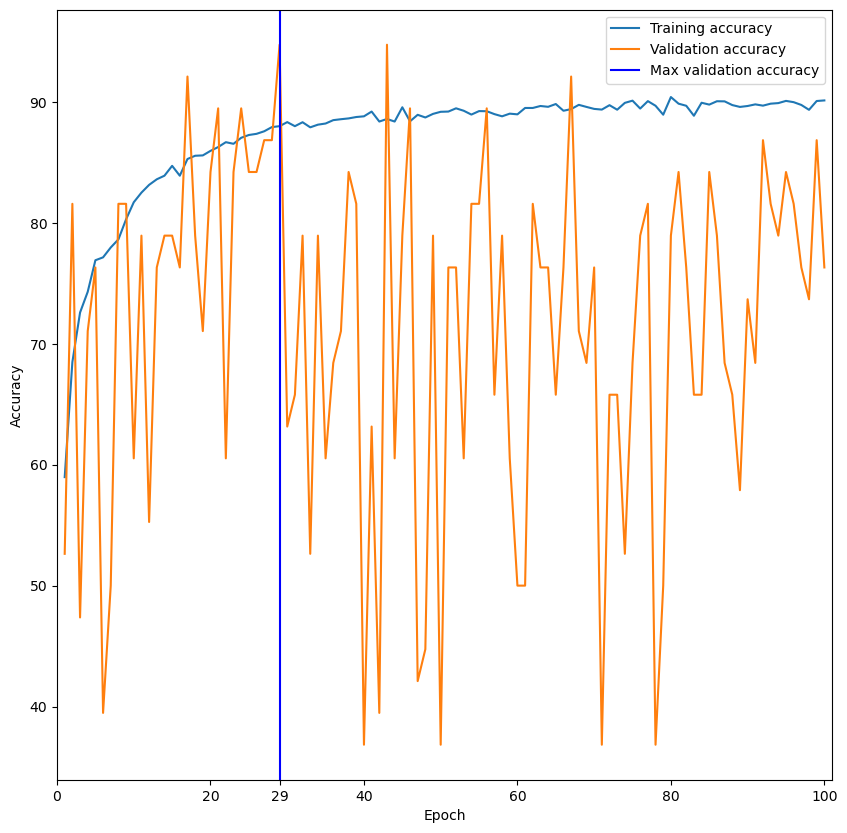

In [201]:
plt.figure(figsize=(10,10))

#plotting the accuracy
plt.plot(batchID,train_acc,label = "Training accuracy")
plt.plot(batchID,val_acc, label = "Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#showing the position of the best values
plt.axvline(x = best_epoch, color = 'b', label = "Max validation accuracy")

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch])
plt.xticks(ticks)

#limit the plot x-values
plt.xlim(0,batchID.max()+1)

plt.legend()

#saving the figure
#plt.savefig("train-val_accuracy")
plt.show()

### Test

Notice that the value of the losses and the accuracy for the train set are computed during the training, so they are not very accurate.

In [202]:
train_dir = os.path.join(data_dir,"train","images")#images
train_dir_patches = os.path.join(data_dir,"train","images_patch")#patches
train_labels_dir = os.path.join(data_dir,"train","labels","train.json")
with open(train_labels_dir) as f:
    train_labels = json.load(f)#labels

train_dataset = HDAdatasetPatches(train_dir,train_dir_patches,train_labels,train = False,
                          grayscale=grayscale,fft=fft)

In [203]:
test(train_dataset,"TRAIN")
test(val_dataset,"VALIDATION")
test(test_dataset,"TEST");

TRAIN set: 100%|█████████████████████████████████████████████████████████████████████| 261/261 [00:54<00:00,  4.80it/s]


TRAIN: Autoencoder Loss: 0.0016, Classifier Loss: 0.8452, Accuracy: 93.4866 in 261 input samples



VALIDATION set: 100%|██████████████████████████████████████████████████████████████████| 38/38 [00:07<00:00,  5.18it/s]


VALIDATION: Autoencoder Loss: 0.0016, Classifier Loss: 0.8595, Accuracy: 94.7368 in 38 input samples



TEST set: 100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.07it/s]

TEST: Autoencoder Loss: 0.0016, Classifier Loss: 0.8864, Accuracy: 84.0000 in 75 input samples

